# Analysis of heterogeneous ABM - NO NETWORK

Assumes a well-mixed heterogeneous population in which agents communicate and observe behaviour of all other agents.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol as sobol_analyze
from SALib.test_functions import Ishigami
import random
import matplotlib.ticker as mtick


In [2]:
from model_heterogeneous_newdata import ConsumatModel

In [19]:
base_config = {
    'TP_percentage': 1,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1600, 
    'seed': 42  
}



In [20]:
model = ConsumatModel(base_config)
for i in range(1):  
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()

print(agent_data.head())

weights_financial = agent_data['Weight_Financial'].values
weights_social = agent_data['Weight_Social'].values
weights_personal = agent_data['Weight_Personal'].values

plt.figure(figsize=(8, 6))
sns.histplot(weights_financial, bins=20, kde=True, color='green')
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.legend(['KDE'], fontsize=14)
plt.tight_layout()
plt.savefig('financial_weight_distribution.png')
plt.close()

plt.figure(figsize=(8, 6))
sns.histplot(weights_social, bins=20, kde=True, color='green')
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.legend(['KDE'], fontsize=14)
plt.tight_layout()
plt.savefig('social_weight_distribution.png')
plt.close()

plt.figure(figsize=(8, 6))
sns.histplot(weights_personal, bins=20, kde=True, color='green')
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)
plt.legend(['KDE'], fontsize=14)
plt.tight_layout()
plt.savefig('personal_weight_distribution.png')
plt.close()


              True_Price_Usage  Repeat  Imitate  Deliberate  Social_Compare  \
Step AgentID                                                                  
1    0                   False   False    False        True           False   
     1                   False   False     True       False           False   
     2                   False   False     True       False           False   
     3                   False   False     True       False           False   
     4                   False   False     True       False           False   

              Satisfaction  Uncertainty  Choice_Changes  \
Step AgentID                                              
1    0            0.451076     0.415446               1   
     1            0.551462     0.696815               1   
     2            0.426531     0.724482               1   
     3            0.653882     0.556788               1   
     4            0.792281     0.865649               1   

              Decision_Mode_Chan

In [44]:


def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)

    return model_data

tp_percentages = np.arange(0, 1.05, 0.05)  
num_steps = 10
all_results = {}
final_adoption_rates = [] 

for tp in tp_percentages:
    base_config['TP_percentage'] = tp
    model = ConsumatModel(base_config)
    model_data = collect_simulation_data(model, num_steps)
    all_results[tp] = model_data
    final_adoption_rate = model_data['Adoption Rate'].iloc[-1]
    final_adoption_rates.append(final_adoption_rate)

def plot_metric(all_results, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))

    for tp, color in zip(all_results.keys(), colors):
        data = all_results[tp]
        if scale_as_percentage:
            plt.plot(data['Step'], data[metric] * 100, label=f'TP_percentage={tp * 100:.0f}%', color=color, marker='o')
        else:
            plt.plot(data['Step'], data[metric], label=f'TP_percentage={tp * 100:.0f}%', color=color, marker='o')

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='TP_percentage', fontsize=12)
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.savefig(f'{filename}.png')
    plt.close()

plot_metric(all_results, 'Adoption Rate', 'Adoption Rate (%)', 'heterogeneous_adoption_rate_over_time')
plot_metric(all_results, 'Avg_F_Satisfaction', 'Average Financial Satisfaction', 'heterogeneous_avg_financial_satisfaction_over_time')
plot_metric(all_results, 'Avg_S_Satisfaction', 'Average Social Satisfaction', 'heterogeneous_avg_social_satisfaction_over_time')
plot_metric(all_results, 'Avg_P_Satisfaction', 'Average Personal Satisfaction', 'heterogeneous_avg_personal_satisfaction_over_time')
plot_metric(all_results, 'Avg_F_Uncertainty', 'Average Financial Uncertainty', 'heterogeneous_avg_financial_uncertainty_over_time')
plot_metric(all_results, 'Avg_S_Uncertainty', 'Average Social Uncertainty', 'heterogeneous_avg_social_uncertainty_over_time')
plot_metric(all_results, 'Avg_P_Uncertainty', 'Average Personal Uncertainty', 'heterogeneous_avg_personal_uncertainty_over_time')



plt.figure(figsize=(12, 10))
plt.plot(tp_percentages, np.array(final_adoption_rates), marker='o')
plt.xlabel('TP introduction percentage (%)', fontsize=14)
plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
plt.ylim(0, 100)
plt.grid(True)
plt.savefig('heterogeneous_final_true_price_adoption_rate.png')
plt.close()

Simulation Progress: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [46]:

plt.figure(figsize=(10, 8))
plt.plot(tp_percentages*100, np.array(final_adoption_rates), marker='o')
plt.xlabel('TP introduction percentage (%)', fontsize=14)
plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
plt.ylim(0, 100)
plt.grid(True)
plt.savefig('heterogeneous_final_true_price_adoption_rate.png')
plt.close()

## Global Sensitivity Analysis

Sobol indices

Saltelli sampling


In [37]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

problem = {
    'num_vars': 3,
    'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold'],
    'bounds': [[0, 1],    # TP_percentage
               [0, 1],    # satisfaction_threshold
               [0, 1]]    # uncertainty_threshold
}

num_samples = 256

param_values = saltelli.sample(problem, num_samples)

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, base_config, num_steps):
    config = base_config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]
    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

num_steps = 10

all_results = Parallel(n_jobs=-1)(
    delayed(run_single_simulation)(params, base_config, num_steps)
    for params in tqdm(param_values, desc='Running simulations')
)

all_results = np.array(all_results)

results_df = pd.DataFrame(all_results, columns=[
    'Adoption Rate',
    'Avg_F_Satisfaction',
    'Avg_S_Satisfaction',
    'Avg_P_Satisfaction',
    'Avg_F_Uncertainty',
    'Avg_S_Uncertainty',
    'Avg_P_Uncertainty'
])
results_df.to_csv('sensitivity_analysis_results.csv', index=False)

sensitivity_results = {}
for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
    Si = sobol.analyze(problem, all_results[:, i], print_to_console=True)
    sensitivity_results[output] = Si
    print(f'Sensitivity analysis for {output}:')
    print(Si)

for key, Si in sensitivity_results.items():
    pd.DataFrame(Si.to_df()).to_csv(f'sensitivity_analysis_{key}.csv', index=False)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_51967/775692210.py:22: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, num_samples)
Running simulations:   0%|          | 9/2048 [00:01<05:10,  6.56it/s]

Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.325597608081521, 8.170966178133064, 7.0786193338679135, 6.451748457454554, 8.905883852508103, 5.346499354007632, 6.425643829048164, 5.90214533912303, 6.835116620000304, 7.23476558740023]
Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.325597608081521, 8.170966178133064, 7.0786193338679135, 6.451748457454554, 8.905883852508103, 5.346499354007632, 6.425643829048164, 5.90214533912303, 6.835116620000304, 7.23476558740023]
Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.32

Running simulations:   1%|          | 16/2048 [01:09<3:20:38,  5.92s/it]

Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.325597608081521, 8.170966178133064, 7.0786193338679135, 6.451748457454554, 8.905883852508103, 5.346499354007632, 6.425643829048164, 5.90214533912303, 6.835116620000304, 7.23476558740023]
Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.325597608081521, 8.170966178133064, 7.0786193338679135, 6.451748457454554, 8.905883852508103, 5.346499354007632, 6.425643829048164, 5.90214533912303, 6.835116620000304, 7.23476558740023]
Product Costs:
[9.614381948503636, 6.999025114201697, 5.930839833836315, 9.837317305467552, 5.661898476902179, 6.699379232903285, 5.712813636623608, 7.927710778909143, 5.554362614158917, 6.482175281653965, 8.32

KeyboardInterrupt: 

In [82]:
import json

with open('/Applications/UNI/ThesisNew/Heterogeneous - no nework/New Data/sensitivity_results.json', 'r') as file:
    data = json.load(file)

source_names = {
    "Adoption Rate": "Adoption Rate",
    "Avg_F_Satisfaction": "Average Financial Satisfaction",
    "Avg_F_Uncertainty": "Average Financial Uncertainty",
    "Avg_P_Satisfaction": "Average Personal Satisfaction",
    "Avg_P_Uncertainty": "Average Personal Uncertainty",
    "Avg_S_Satisfaction": "Average Social Satisfaction",
    "Avg_S_Uncertainty": "Average Social Uncertainty"
}

parameter_names = {
    "TP_percentage": "TP Percentage",
    "satisfaction_threshold": "Satisfaction Threshold",
    "uncertainty_threshold": "Uncertainty Threshold",
    "min_increase_percentage": "Min Increase Percentage",
    "max_increase_percentage": "Max Increase Percentage"
}

parameters = list(parameter_names.keys())
df_list = []

for measure, values in data.items():
    for stat in ['S1', 'ST', 'S1_conf', 'ST_conf']:
        for param, val in zip(parameters, values[stat]):
            df_list.append([measure, stat, param, val])

df = pd.DataFrame(df_list, columns=['Measure', 'Statistic', 'Parameter', 'Value'])

df['Measure'] = df['Measure'].map(source_names)
df['Parameter'] = df['Parameter'].map(parameter_names)

save_dir = "/Applications/UNI/ThesisNew/Heterogeneous - no nework/New Data/Heterogeneous_plots"
os.makedirs(save_dir, exist_ok=True)

def plot_sensitivity_by_measure(df, statistic):
    measures = df['Measure'].unique()
    for measure in measures:
        plt.figure(figsize=(7, 4))
        subset_df = df[(df['Measure'] == measure) & (df['Statistic'].str.startswith(statistic))]
        
        sns.stripplot(data=subset_df[subset_df['Statistic'] == statistic], 
                      x='Value', y='Parameter', hue='Measure', palette='Greens', jitter=False, size=10)
        
        main_data = subset_df[subset_df['Statistic'] == statistic]
        conf_data = subset_df[subset_df['Statistic'] == f'{statistic}_conf']
        for idx, row in main_data.iterrows():
            plt.errorbar(x=row['Value'], y=row['Parameter'], 
                         xerr=conf_data[conf_data['Parameter'] == row['Parameter']]['Value'].values, 
                         fmt='o', color='black', elinewidth=2, capsize=4, alpha=0.4)

        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
        plt.xlabel('Sensitivity Index')
        plt.ylabel('Parameters')
        plt.legend(title='Measure', bbox_to_anchor=(1, 0), loc='lower right')

        plt.grid(True)
        plt.tight_layout()

        plt.savefig(os.path.join(save_dir, f"heterogeneous_plot_{statistic}_{measure.replace(' ', '_')}.png"))
        plt.close()
        plt.show()

plot_sensitivity_by_measure(df, 'S1')

plot_sensitivity_by_measure(df, 'ST')


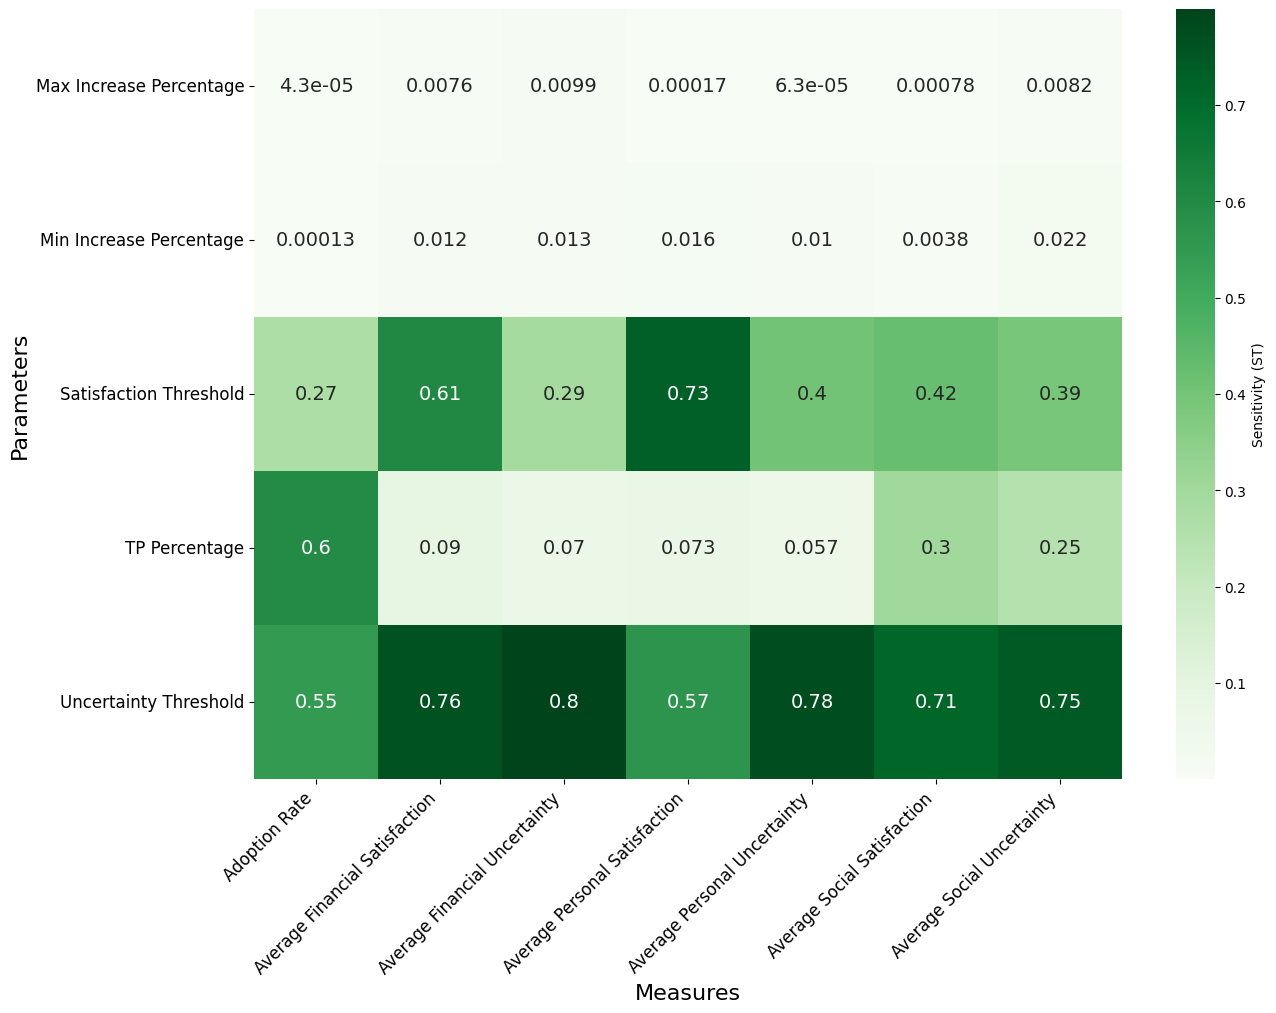

In [81]:
def plot_heatmap(df):
    heatmap_df = df[df['Statistic'] == 'ST'].pivot(index='Parameter', columns='Measure', values='Value')

    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_df, annot=True, cmap='Greens', cbar_kws={'label': 'Sensitivity (ST)'}, annot_kws={"size": 14})
    plt.xlabel('Measures', fontsize=16)
    plt.ylabel('Parameters', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)  # Skew x-axis labels
    plt.yticks(fontsize=12)


    #plt.savefig(os.path.join(save_dir, "sensitivity_analysis_heatmap.png"))
    #plt.close()
    plt.show()

plot_heatmap(df)